Problem description

We are given three columns of integers with a row for each node. The first two columns contain x
and y coordinates of the node positions in a plane. The third column contains node costs. 

The goal is to select exactly 50% of the nodes (if the number of nodes is odd we round the number of nodes to
be selected up) and form a Hamiltonian cycle (closed path) through this set of nodes such that the
sum of the total length of the path plus the total cost of the selected nodes is minimized.
The distances between nodes are calculated as Euclidean distances rounded mathematically to
integer values. The distance matrix should be calculated just after reading an instance and then only
the distance matrix (no nodes coordinates) should be accessed by optimization methods to allow
instances defined only by distance matrices.

Greedy heuristics

Implement three methods:

- Random solution
- Nearest neighbor
- Greedy cycle

adapted to our problem.

For each greedy method generate 200 solutions starting from each node. Generate also 200 random
solutions.

The report should contain:

- Description of the problem
- Pseudocode of all implemented algorithms
- Results of a computational experiment: for each instance and method min, max and average
value of the objective function.
- 2D visualization of the best solution for each instance and methods. Cost of nodes should be
presented e.g. by a color, greyscale, or size.
- (link to) source code
- Conclusions

In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
warnings.filterwarnings("ignore")

In [2]:
def calculate_euclidean_distance(node1, node2):
    return np.round(np.sqrt((node1['x'] - node2['x'])**2 + (node1['y'] - node2['y'])**2))

In [3]:
def get_distance_matrix(df):
    num_nodes = df.shape[0]
    distance_matrix = np.zeros((num_nodes, num_nodes))
    for i in range(num_nodes):
        for j in range(i, num_nodes):
            node1 = df.iloc[i]
            node2 = df.iloc[j]
            distance = calculate_euclidean_distance(node1, node2)
            distance_matrix[i,j] = distance + node2['cost']
            distance_matrix[j,i] = distance + node1['cost']
    return distance_matrix

## Random search

In [4]:
def random_search(distance_matrix, current_node_index=None):
    to_visit = list(range(len(distance_matrix)))
    if not current_node_index:
        current_node_index = np.random.choice(len(to_visit))
    current_node = to_visit[current_node_index]
    solution = [current_node]
    total_cost = distance_matrix[current_node, current_node]
    to_visit.pop(current_node_index)
    
    while to_visit:
        next_node_index = np.random.choice(len(to_visit))
        next_node = to_visit[next_node_index]
        total_cost += distance_matrix[current_node, next_node]
        solution.append(next_node)
        to_visit.pop(next_node_index)
        current_node = next_node
    
    solution.append(solution[0])
    total_cost += distance_matrix[solution[-1], solution[0]]
    
    return solution, total_cost

## Nearest neighbor

In [5]:
import numpy as np

def nearest_neighbor(distance_matrix, current_node_index=None):
    to_visit = list(range(len(distance_matrix)))
    if current_node_index is None:
        current_node_index = np.random.choice(len(to_visit))
    current_node = to_visit[current_node_index]
    solution = [current_node]
    total_cost = 0
    to_visit.pop(current_node_index)
    
    while to_visit:
        closest_neighbor = None
        closest_neighbor_index = None
        closest_neighbor_distance = float("inf")
        for i, neighbor in enumerate(to_visit): 
            neighbor_distance = distance_matrix[current_node, neighbor] 
            if neighbor_distance < closest_neighbor_distance:
                closest_neighbor = neighbor
                closest_neighbor_distance = neighbor_distance
                closest_neighbor_index = i
        
        total_cost += closest_neighbor_distance
        solution.append(closest_neighbor)
        to_visit.pop(closest_neighbor_index)
        current_node = closest_neighbor
        
    solution.append(solution[0])
    total_cost += distance_matrix[solution[-1], solution[0]]
    
    return solution, total_cost


## Greedy cycle

In [6]:
def greedy_cycle(distance_matrix, current_node_index=None):
    to_visit = list(range(len(distance_matrix)))
    if not current_node_index:
        current_node_index = np.random.choice(len(to_visit))
    current_node = to_visit[current_node_index]
    solution = [current_node]
    total_cost = distance_matrix[current_node, current_node]
    to_visit.pop(current_node_index)
    
    while to_visit:
        closest_neighbor = None
        closest_neighbor_index = None
        closest_neighbor_position = None
        closest_neighbor_distance = float("inf")
        for i in range(len(to_visit)):
            neighbor = to_visit[i]
            if len(solution) == 1:
                neighbor_distance = distance_matrix[current_node][neighbor] + distance_matrix[neighbor][current_node]
                closest_neighbor = neighbor
                closest_neighbor_distance = neighbor_distance
                closest_neighbor_index = i
                closest_neighbor_position = 1
            else:
                for j in range(1, len(solution)):
                    node1 = solution[j-1]
                    node2 = solution[j]
                    neighbor_distance = distance_matrix[node1][neighbor] + distance_matrix[neighbor][node2] \
                                                                         - distance_matrix[node1, node2]
                    if neighbor_distance < closest_neighbor_distance:
                        closest_neighbor = neighbor
                        closest_neighbor_distance = neighbor_distance
                        closest_neighbor_index = i
                        closest_neighbor_position = j
        
        total_cost += closest_neighbor_distance
        solution.insert(closest_neighbor_position, closest_neighbor)
        to_visit.pop(closest_neighbor_index)
        
    solution.append(solution[0])
    total_cost += distance_matrix[solution[-1], solution[0]]
    
    return solution, total_cost

In [7]:
def run_experiment(distance_matrix, algorithm, consider_current_index=False):
    
    num_repetitions = 2
    solutions = list()
    total_costs = list()
    
    for repetition in range(num_repetitions):
        if consider_current_index:
            results = algorithm(distance_matrix, repetition)
        else:
            results = algorithm(distance_matrix)
        
        solutions.append(results[0])
        total_costs.append(results[1])
    
    min_cost = min(total_costs)
    max_cost = max(total_costs)
    avg_cost = sum(total_costs) / len(total_costs)
    best_solution = solutions[np.argmin(total_costs)]
    
    return min_cost, max_cost, avg_cost, best_solution

In [8]:
def get_results(file_name):
    path = "../data"
    data = pd.read_csv(f"{path}/{file_name}.csv", sep=';', header=None, names=['x', 'y', 'cost'])
    selected_nodes = data.sample(frac=0.5)
    distance_matrix = get_distance_matrix(selected_nodes)
    
    best_solutions = dict()
    results_df = pd.DataFrame(columns=['algorithm', 'min', 'avg', 'max'])
    for algo in (random_search, nearest_neighbor, greedy_cycle):
        if algo is random_search:
            min_cost, max_cost, avg_cost, best_solution = run_experiment(distance_matrix, algo)
        else:
            min_cost, max_cost, avg_cost, best_solution = run_experiment(distance_matrix, algo, True)
        results_df = results_df.append({'algorithm': algo.__name__, 'min': min_cost, 'avg': avg_cost, 'max': max_cost}, ignore_index=True)
        best_solutions[algo.__name__] = best_solution
    return best_solutions, results_df, selected_nodes

In [9]:
instances = ['A', 'B', 'C', 'D']
dataframes = dict()
all_best_solutions = dict()
datas = dict()
for instance in instances:
    file = f'TSP{instance}'
    best_solutions, results_df, data = get_results(file)
    dataframes[file] = results_df
    all_best_solutions[file] = best_solutions
    datas[file] = data

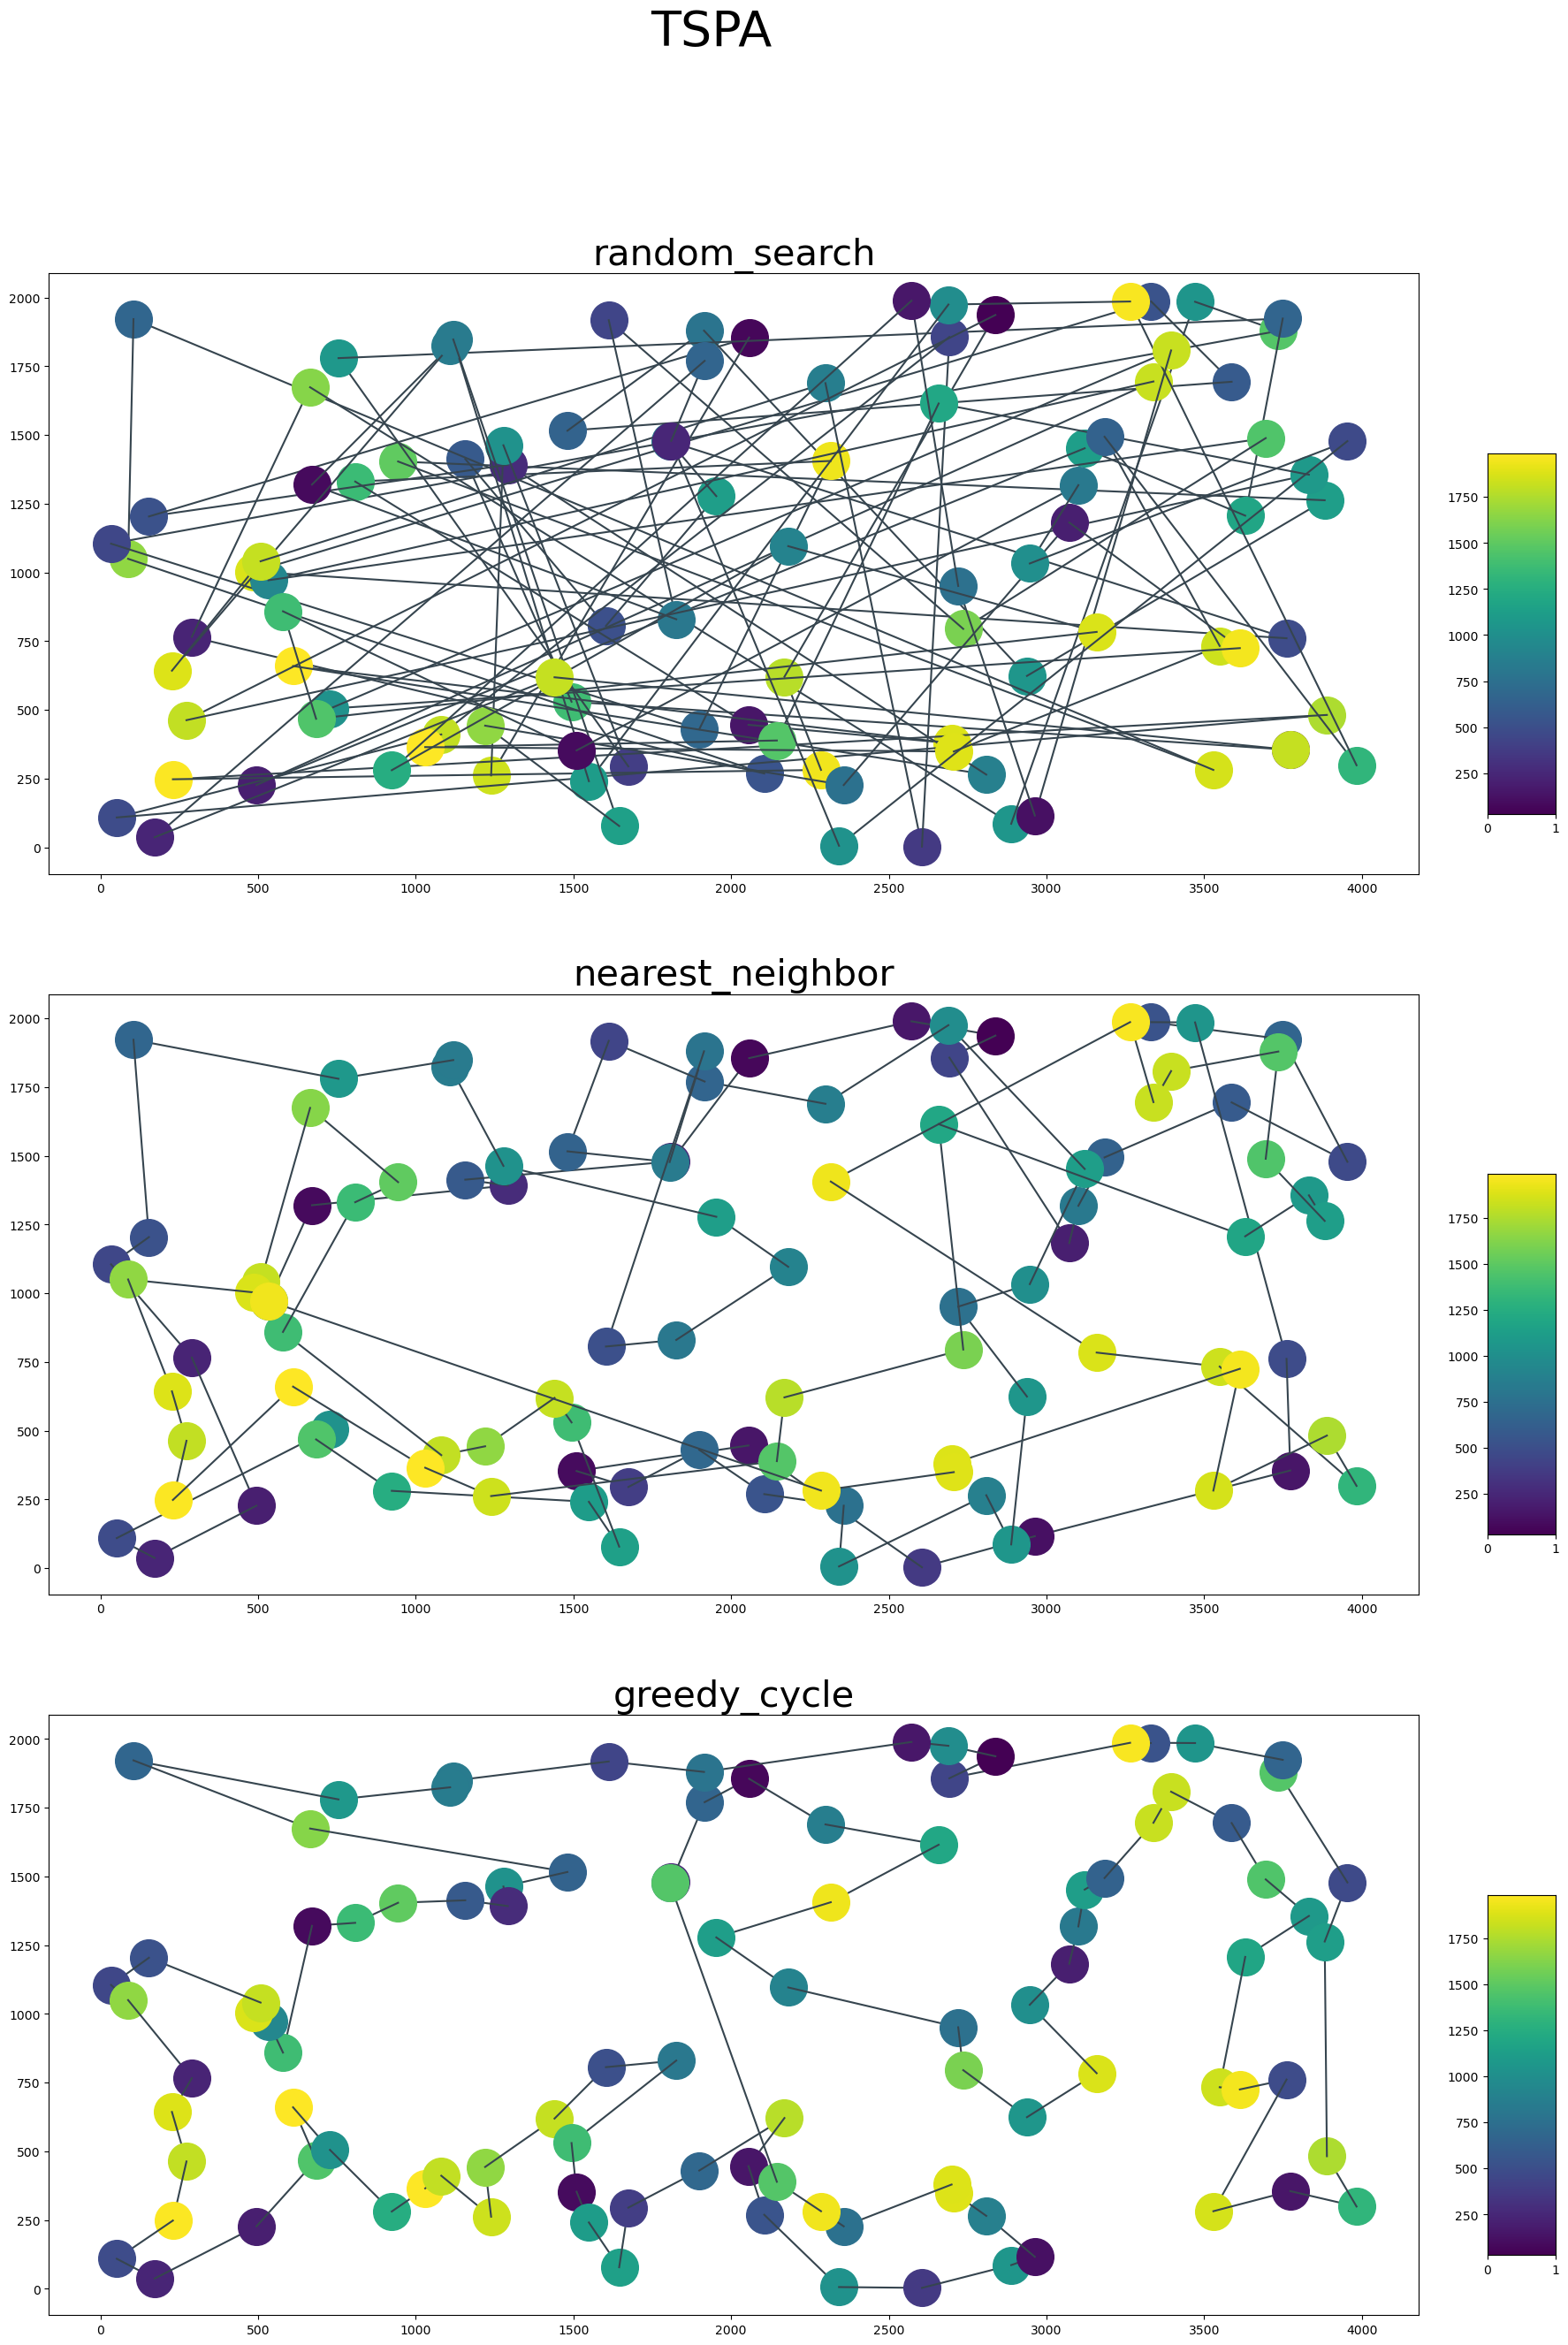

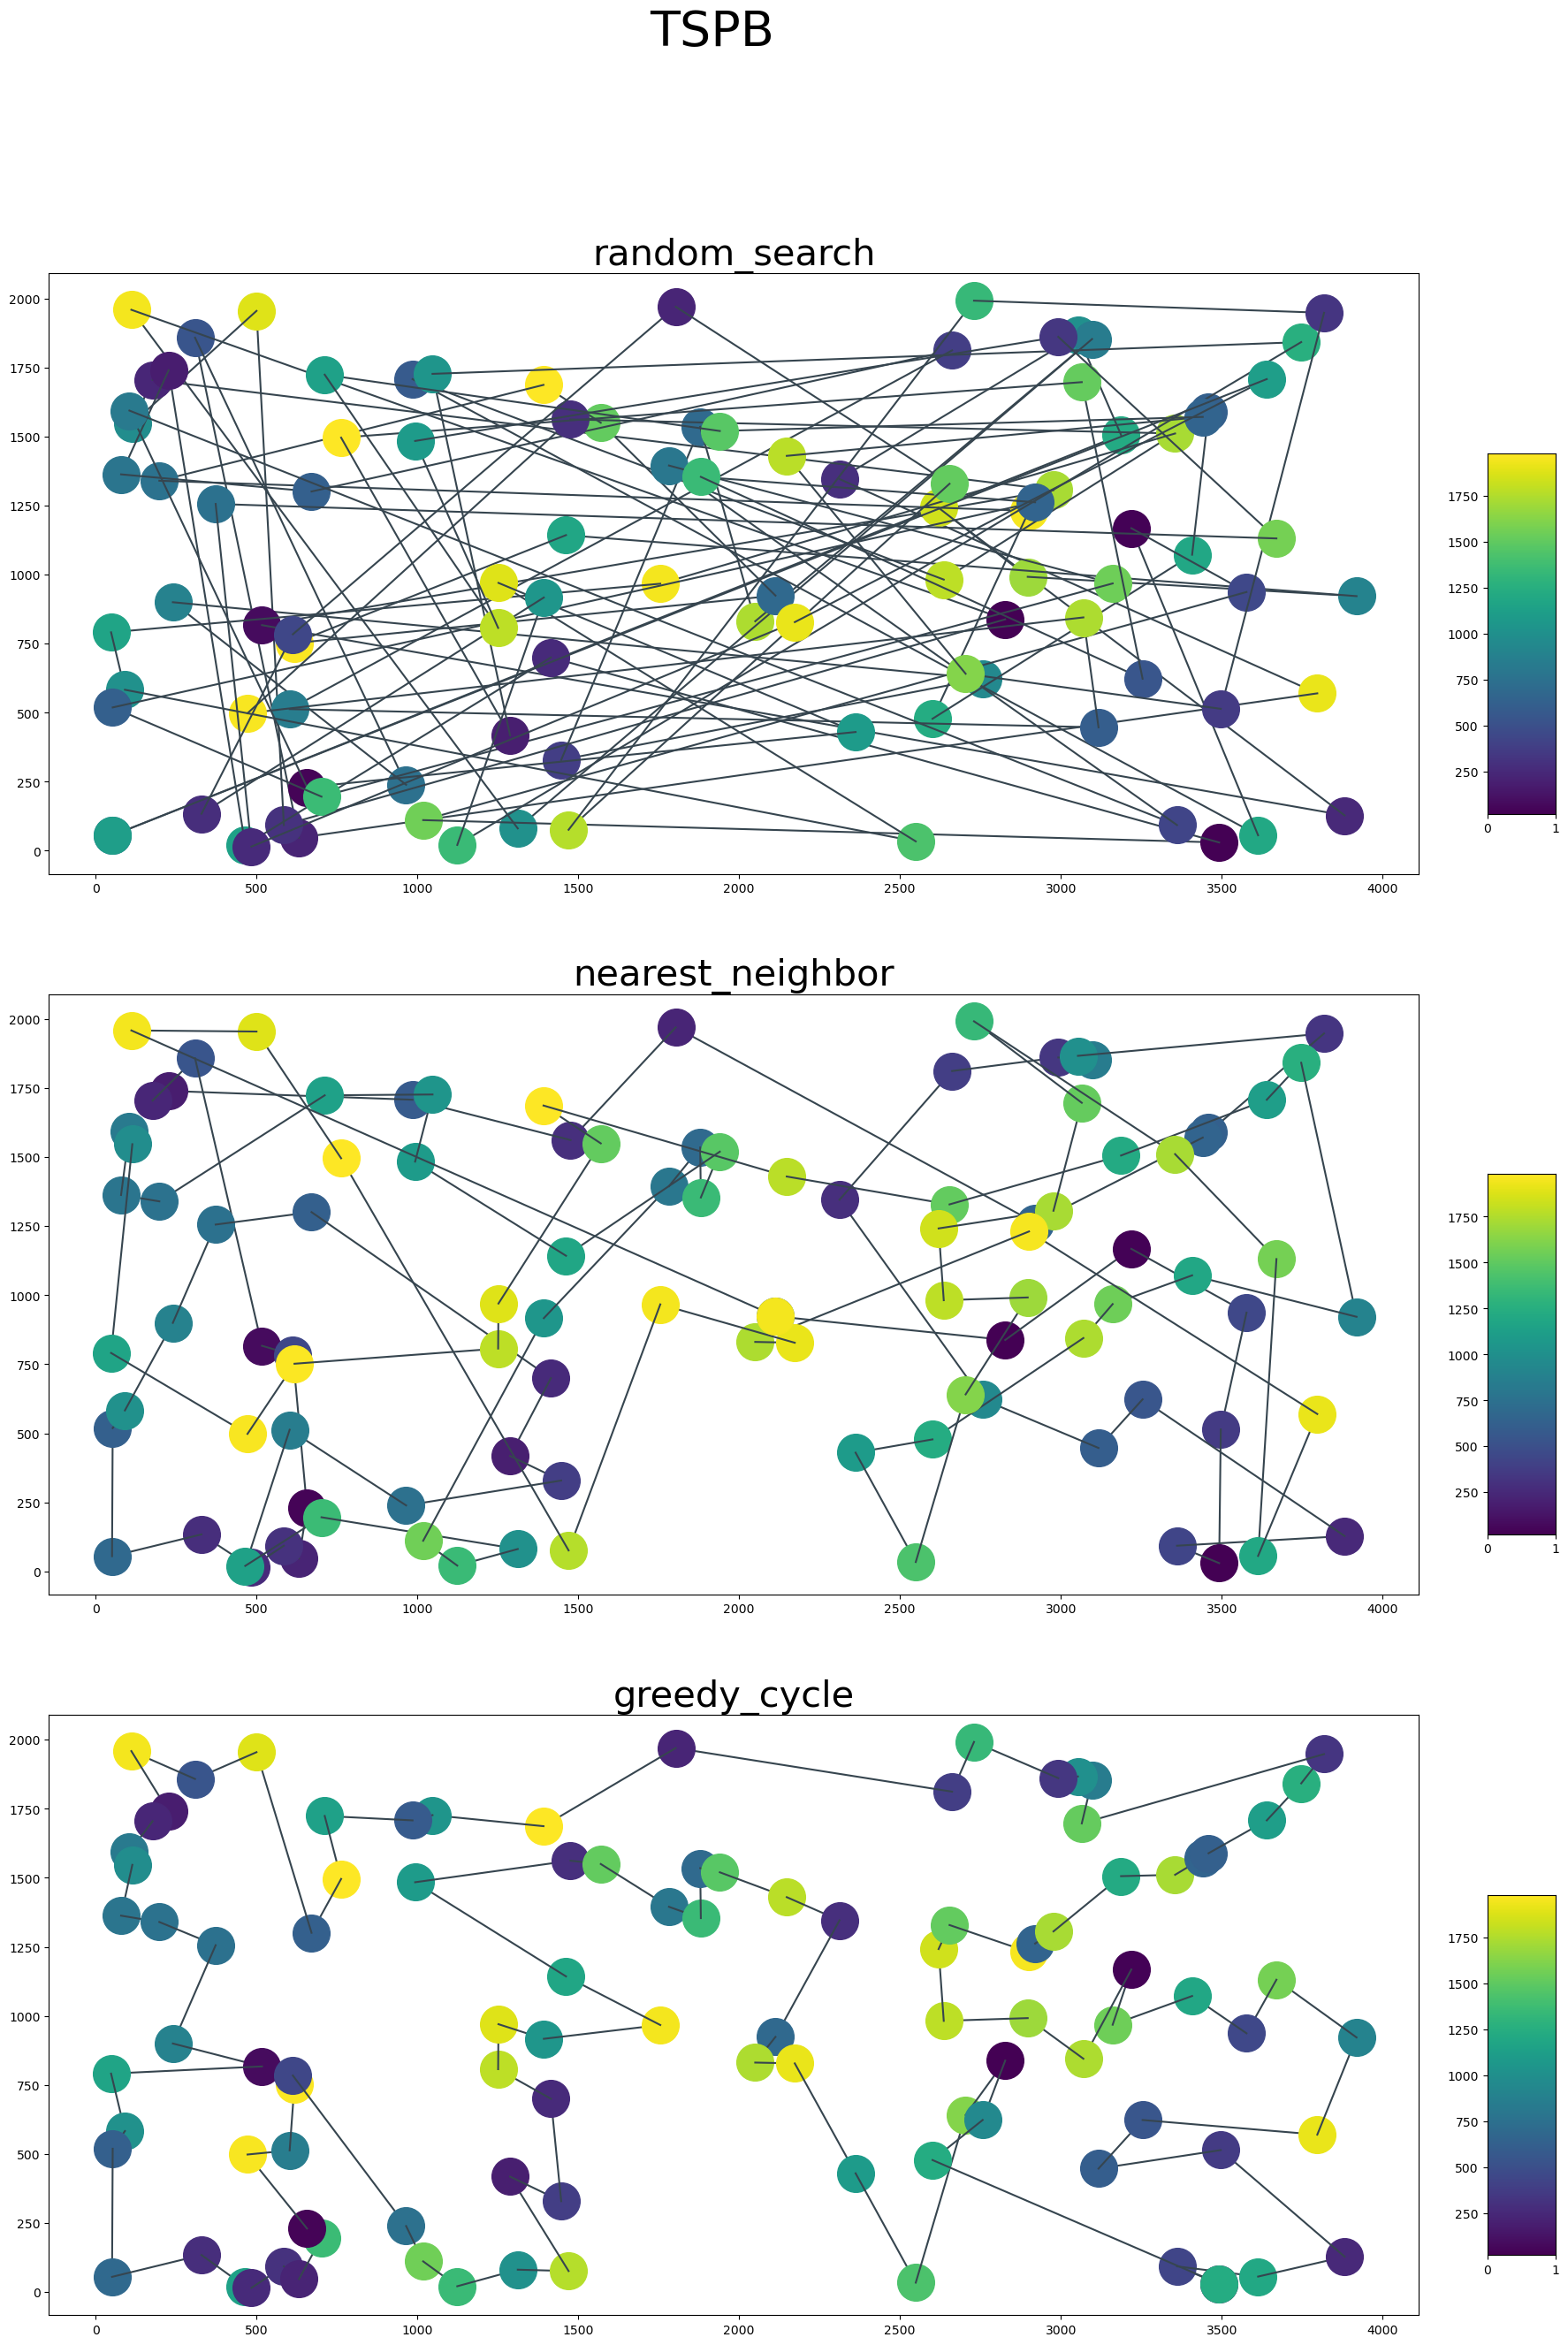

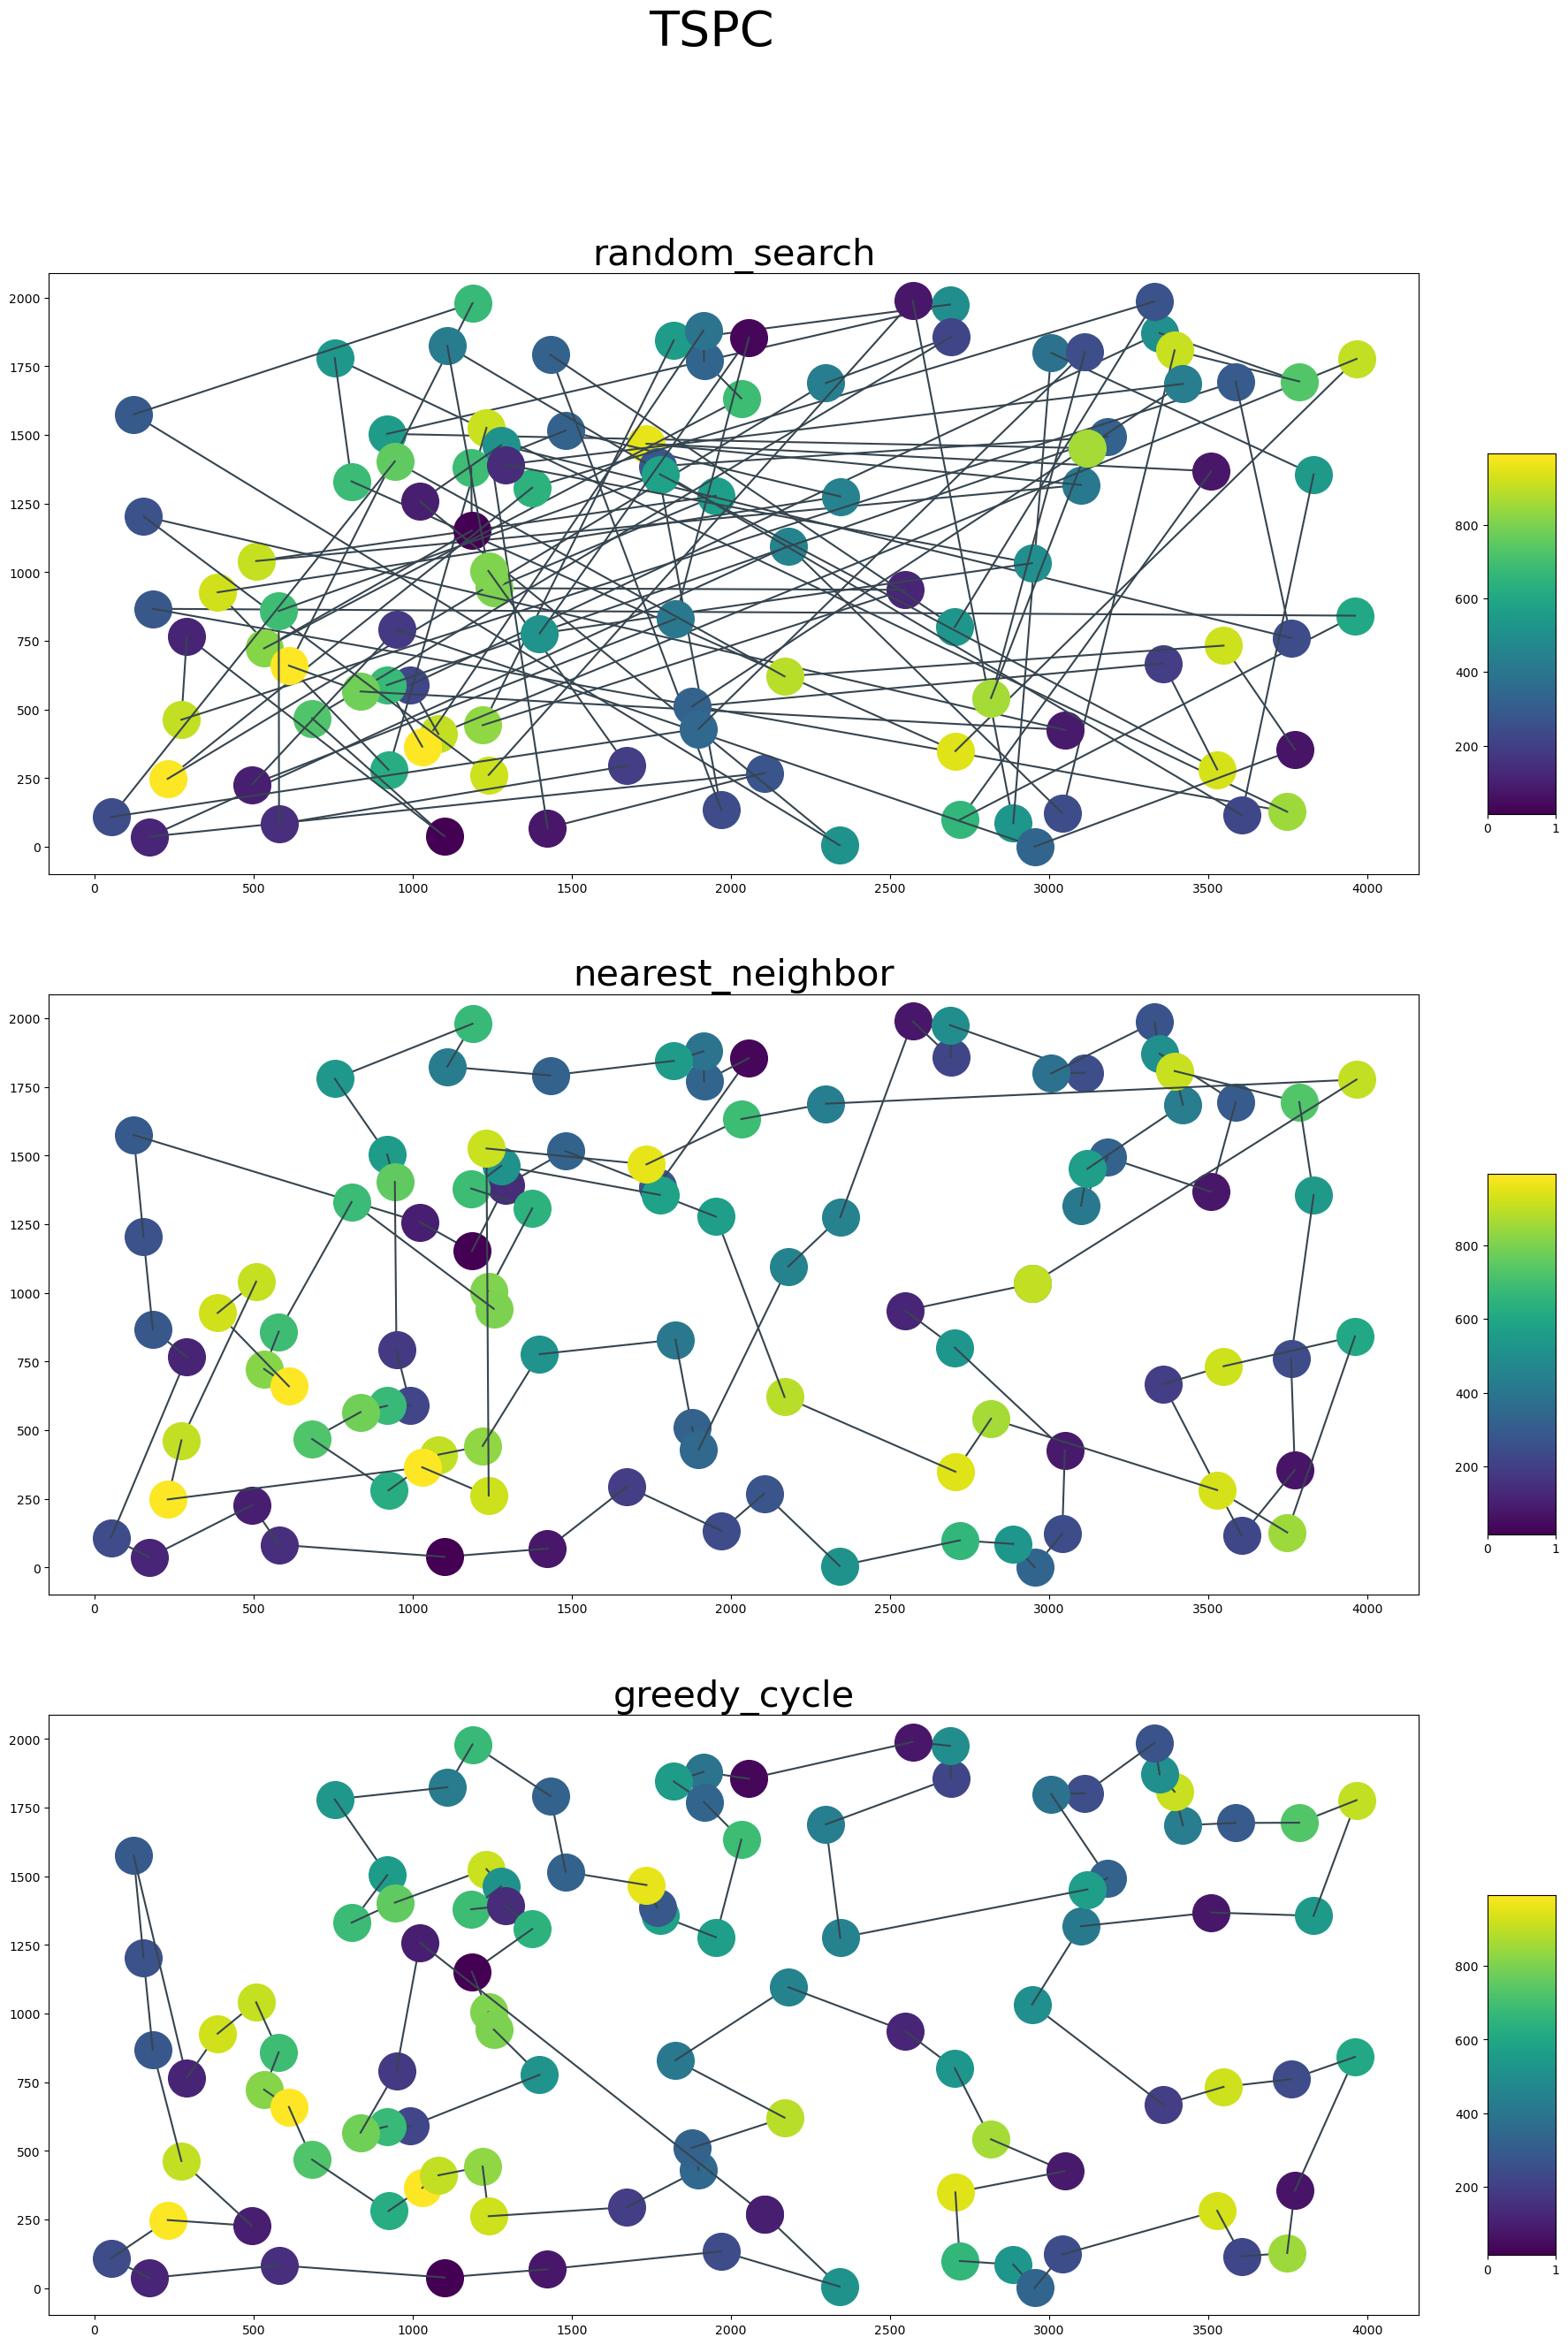

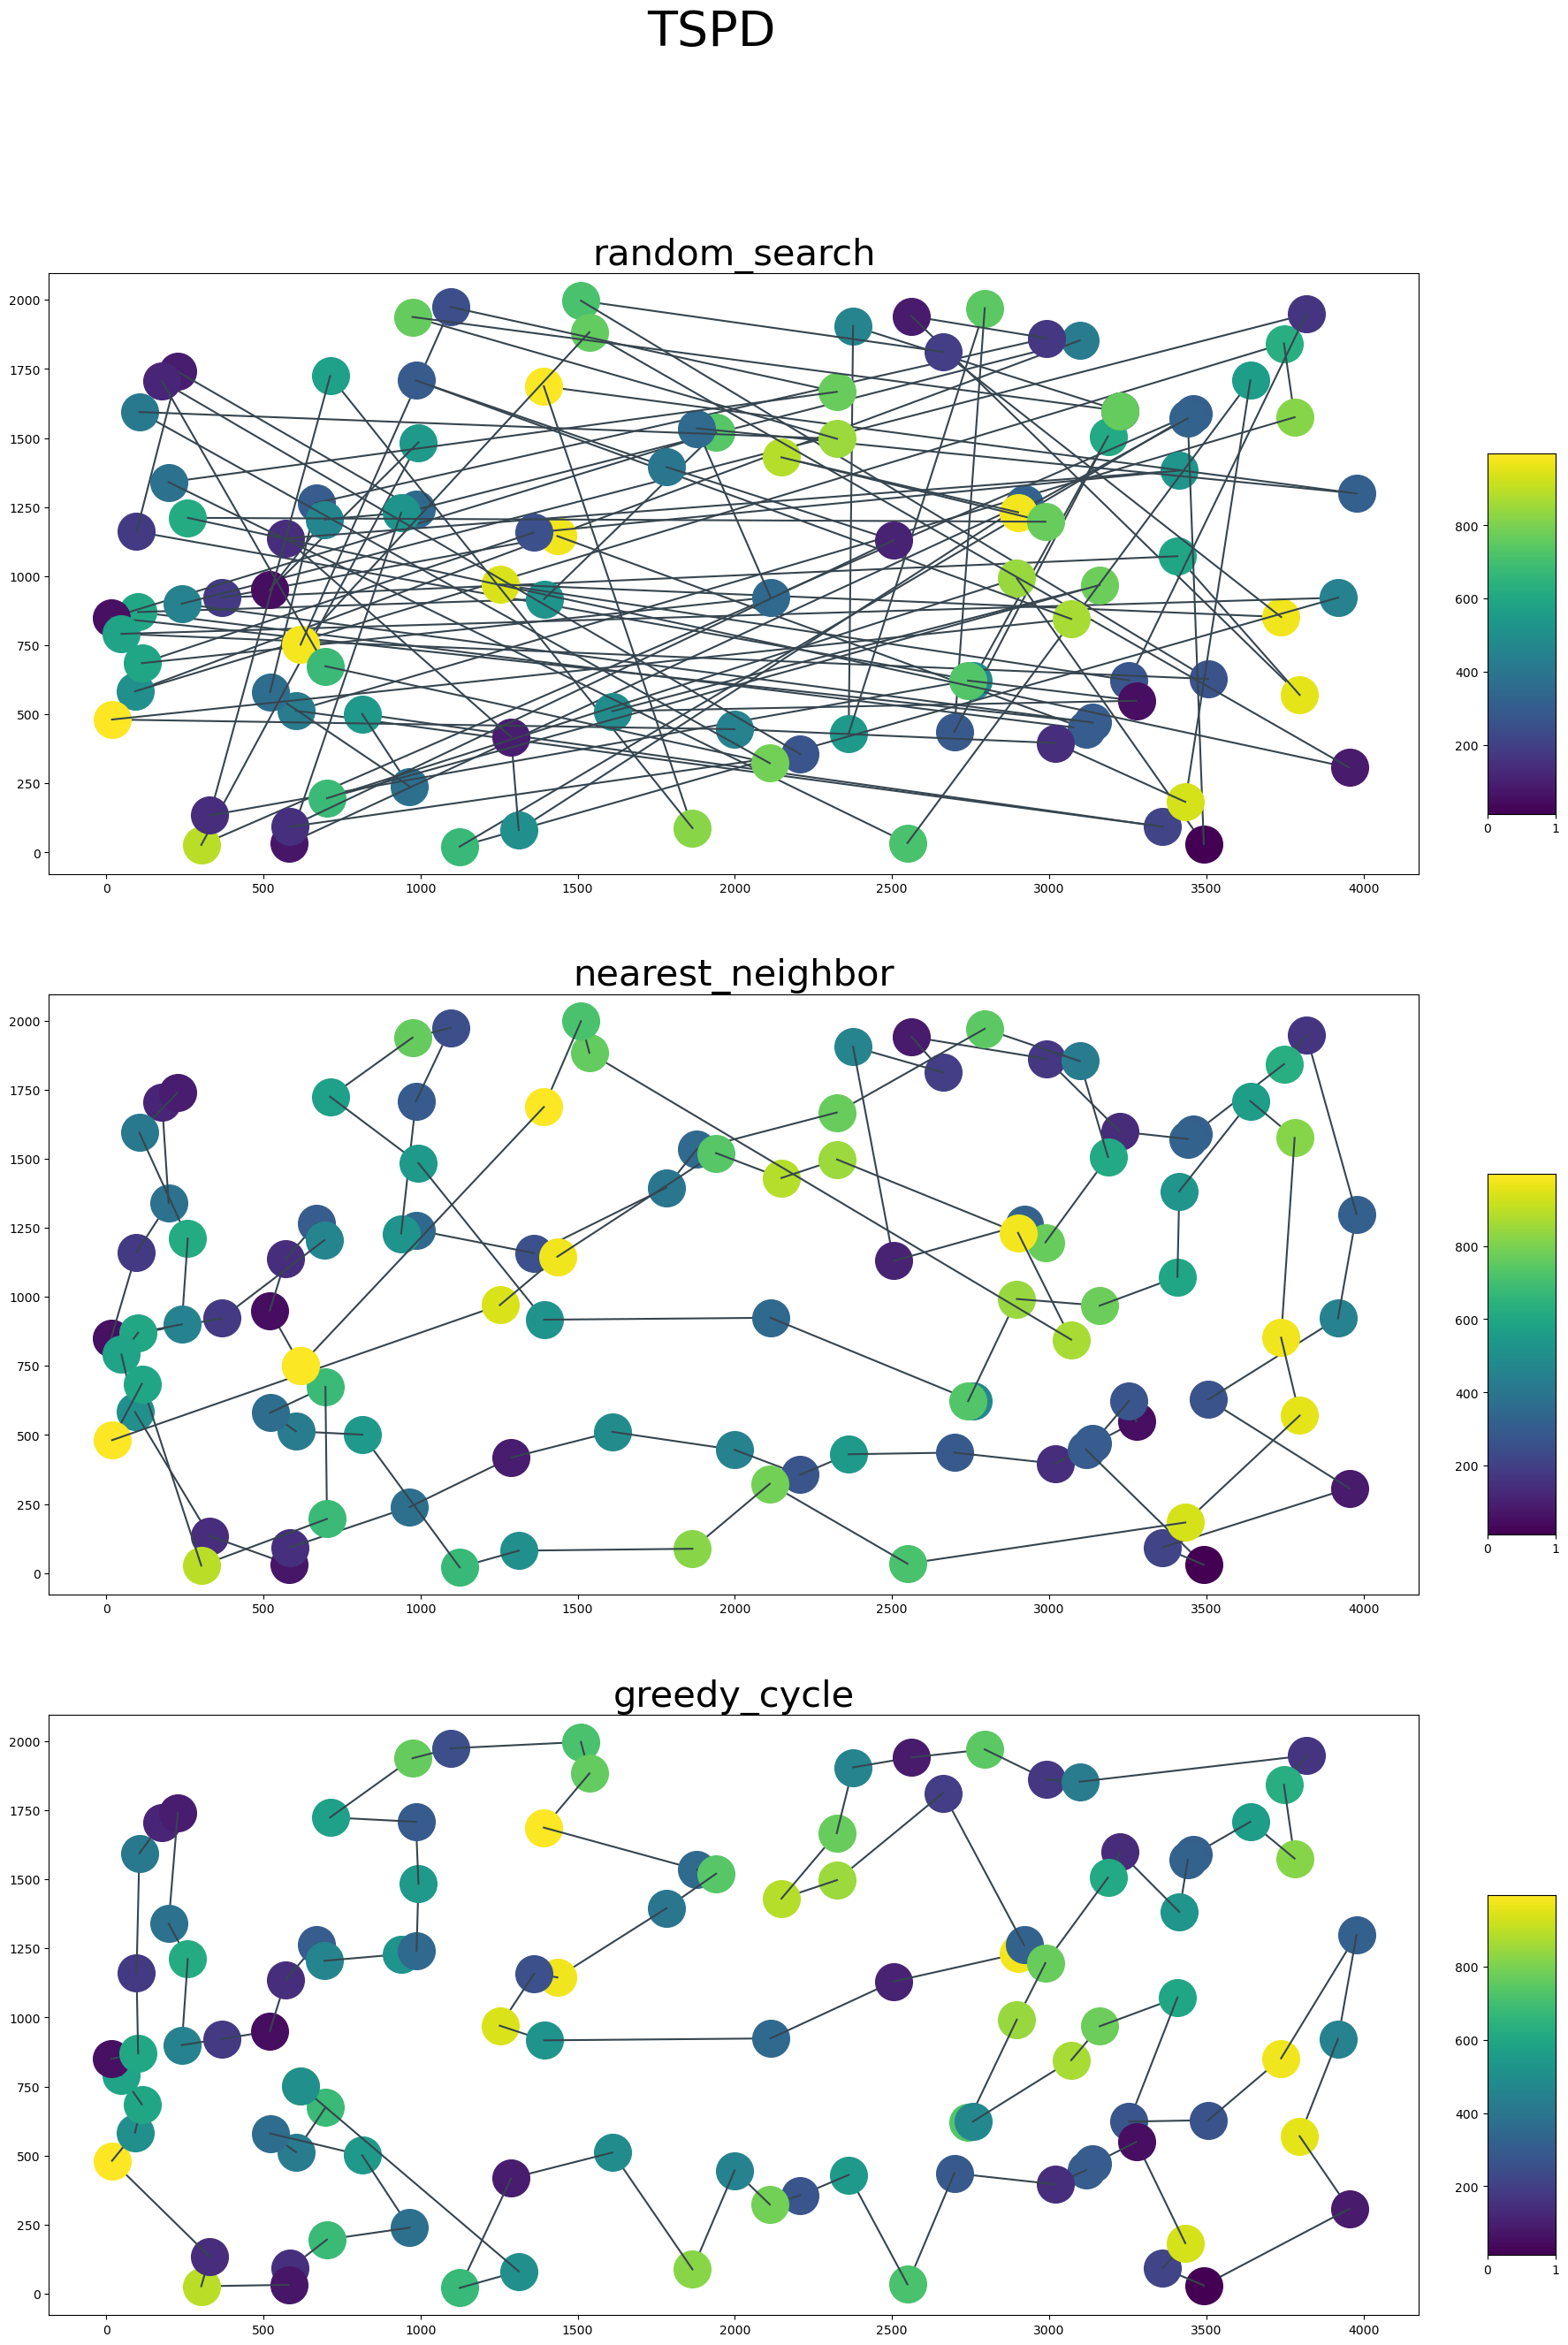

In [10]:
for instance, result in all_best_solutions.items():
    fig, ax = plt.subplots(3, 1, figsize=(20, 30))
    ax = ax.flatten()
    idx = 0
    fig.suptitle(instance, fontsize=40)

    df = datas[instance]
    weights = df['cost']
    
    cmap = plt.cm.viridis
    norm = mcolors.Normalize(vmin=min(weights), vmax=max(weights))
    
    
    for algo, solution in result.items():
        ax[idx].set_title(algo, fontsize=30)
        for i in range(len(solution)-1):
            x, y, cost = df.iloc[solution[i]]['x'], df.iloc[solution[i]]['y'], df.iloc[solution[i]]['cost']
            x_next, y_next = df.iloc[solution[i+1]]['x'], df.iloc[solution[i+1]]['y']
            
            ax[idx].plot(x, y, "o", markersize=30, color=cmap(norm(cost)))
            ax[idx].plot((x, x_next), (y, y_next), "-", color='#36454f')
        x, y = df.iloc[solution[0]]['x'], df.iloc[solution[0]]['y']
        ax[idx].plot((x, x_next), (y, y_next), "-", color='#36454f')
        ax[idx].plot(x_next, y_next, 'o', markersize=30, color=cmap(norm(cost)))
    
        axins = ax[idx].inset_axes([1.05, 0.1, 0.05, 0.6], transform=ax[idx].transAxes)
        gradient = np.linspace(0, 1, 256).reshape(-1, 1)

        axins.imshow(gradient, aspect='auto', cmap=cmap, origin='lower', extent=[0, 1, min(weights), max(weights)])
        
        idx += 1
        
    # plt.savefig(f'plots/{instance}.png', dpi=300)